In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table 
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

<function matplotlib.pyplot.show(*args, **kw)>

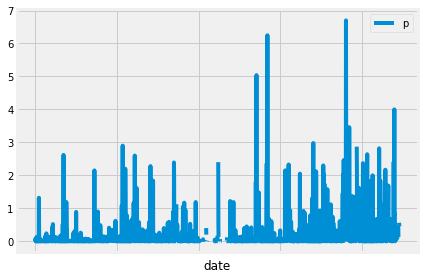

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
#engine.execute("Select * From Measurement order by date desc limit 12").fetchall()

prev_year = dt.date(year=2017, month=8, day=23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
  
precip_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

precip_df = pd.DataFrame(precip_results, columns=["date", "prcp"])
precip_df.set_index("date", inplace=True)
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.xticks(rotation="45")
plt.legend("precipitation")
plt.tight_layout()
plt.show


![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
inspector = inspect(engine)
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to show how many stations are available in this dataset?
station_results = session.query(func.count(Station.station)).all()
station_results

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station_results = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
conn = engine.connect()
data_1 = pd.read_sql("Select * From measurement", conn)
data_1.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [18]:
conn = engine.connect()
data_2 = pd.read_sql("Select * From station", conn)
data_2.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [19]:
combined_data = pd.merge(data_1, data_2, on="station", how="inner")
combined_data.head()

,id_x,station,date,prcp,tobs,id_y,name,latitude,longitude,elevation
0,1,USC00519397,2010-01-01,0.08,65.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00519397,2010-01-02,0.00,63.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,3,USC00519397,2010-01-03,0.00,74.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,4,USC00519397,2010-01-04,0.00,76.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,5,USC00519397,2010-01-06,NaN,73.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()

min_temp, max_temp, avg_temp

([(54.0)], [(85.0)], [(71.66378066378067)])

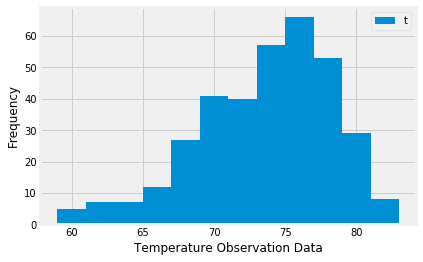

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_results = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station=='USC00519281').filter(Measurement.date>=prev_year).\
order_by(Measurement.date.desc()).all()
tobs_results

tobs_df = pd.DataFrame(tobs_results, columns=["date", "tobs"])
tobs_df.head()

x = tobs_df["tobs"]

plt.hist(x, bins=12)
plt.xlabel("Temperature Observation Data")
plt.ylabel("Frequency")
plt.legend("tobs")
plt.show()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = dt.date(2011, 2, 28)
trip_end = dt.date(2011, 3, 5)

trip_query = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date>=trip_start).filter(Measurement.date<=trip_end).all()
trip_query

trip_temps = pd.DataFrame(trip_query, columns=['Date', 'Tobs'])
trip_temps.head()

trip_results = (calc_temps(trip_start, trip_end))
print(trip_results)


[(61.0, 69.75510204081633, 75.0)]


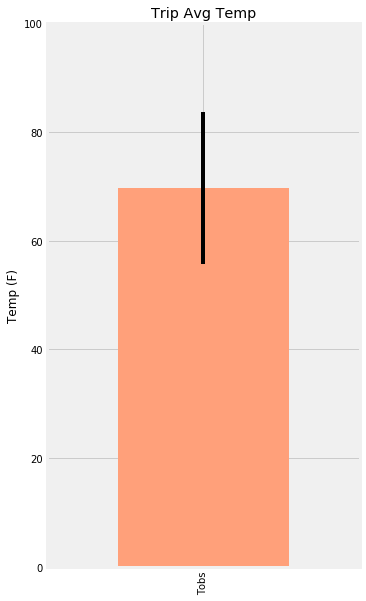

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_avg = trip_temps.mean()
trip_temp_change = (trip_temps["Tobs"].max()-trip_temps["Tobs"].min())


ptp = trip_temp_avg.plot(legend=False, kind="bar", color="lightsalmon", yerr=trip_temp_change, width=0.6, figsize=(5, 10))
ptp.set_title("Trip Avg Temp")
ptp.set_ylabel("Temp (F)")
ptp.set_ylim(0,100)
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_results = session.query(Measurement.station.label("Station"), Station.name.label("Station Name"), Station.latitude.label("Station Latitude"), Station.longitude.label("Station Longitude"), Station.elevation.label("Station Elevation"), func.sum(Measurement.prcp).label("Station")).\
filter(Measurement.date>=trip_start).filter(Measurement.date<=trip_end).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

rain_df = pd.DataFrame(rain_results)
rain_df


,Station,Station Name,Station Latitude,Station Longitude,Station Elevation,Station
0,USC00518838,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,20.97
1,USC00519281,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,20.07
2,USC00519523,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,19.71
3,USC00514830,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,17.64
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,13.05
5,USC00513117,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,12.96
6,USC00519397,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,12.42
7,USC00511918,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,5.67
8,USC00517948,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,NaN


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
